In [27]:
import numpy as np
from matplotlib import pyplot as plt
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from module.interpolate import Interpolator
import matplotlib.patches as mpatches

In [76]:
init_label = mpatches.Patch(color='darkblue', label='Initial position')
final_label = mpatches.Patch(color='green', label='Final position')
plot_label = mpatches.Patch(color='cornflowerblue', label='Trajectories')
stream_label = mpatches.Patch(color='grey', label='Velocity field')
stranded_label = mpatches.Patch(color='red', label='Stranded particles')

---

Plastic pollution in the ocean is a worldwide discussed topic because the consequences are disruptive for the environment, harming the ecosystem and posing a threat to marine life and human health. This settles why it is crucial to understand the dynamics of plastic particle transport in the ocean. By implementing the Langrangian particle method it is possible to predict where plastic particles will end up from their initial position in the ocean, which in turn will give us a better overview and a possiblity to initiate countermeasures. 

The Langrangian method consists of representing the plastic particles as numerical points and simulating the individual particles trajectories as they are traveling with the wind and current. The result is a simulation that calculates the probability of finding particles at specific locations at a given time. We do not need to model the fluid itself, as this information is produced and simulated by the Meteorological Institute [1]. Using this data, we access a more realistic understanding of the movement of the particles as well as accumulation zones.

# Problem 1


# Simulation of single particle in analytical velocity field

Velocity field is given by

$$ v_x = −\pi A \sin(\pi f(x,t)) \cos(\pi y) $$

$$ v_y = \pi A \cos(\pi f(x,t)) \sin(\pi y) \frac{\partial f(x,t)}{\partial x}$$

$$ f(x,t) = a(t)x^2 + b(t)x$$

$$ a(t) = \epsilon \sin(\omega t)$$

$$ b(t) = 1 −2 \epsilon \sin(\omega t)$$

In [29]:
from module.utilities import run_steplength_test
from module.interpolate import velocity

## Simulation for one particle with different timesteps $dt$

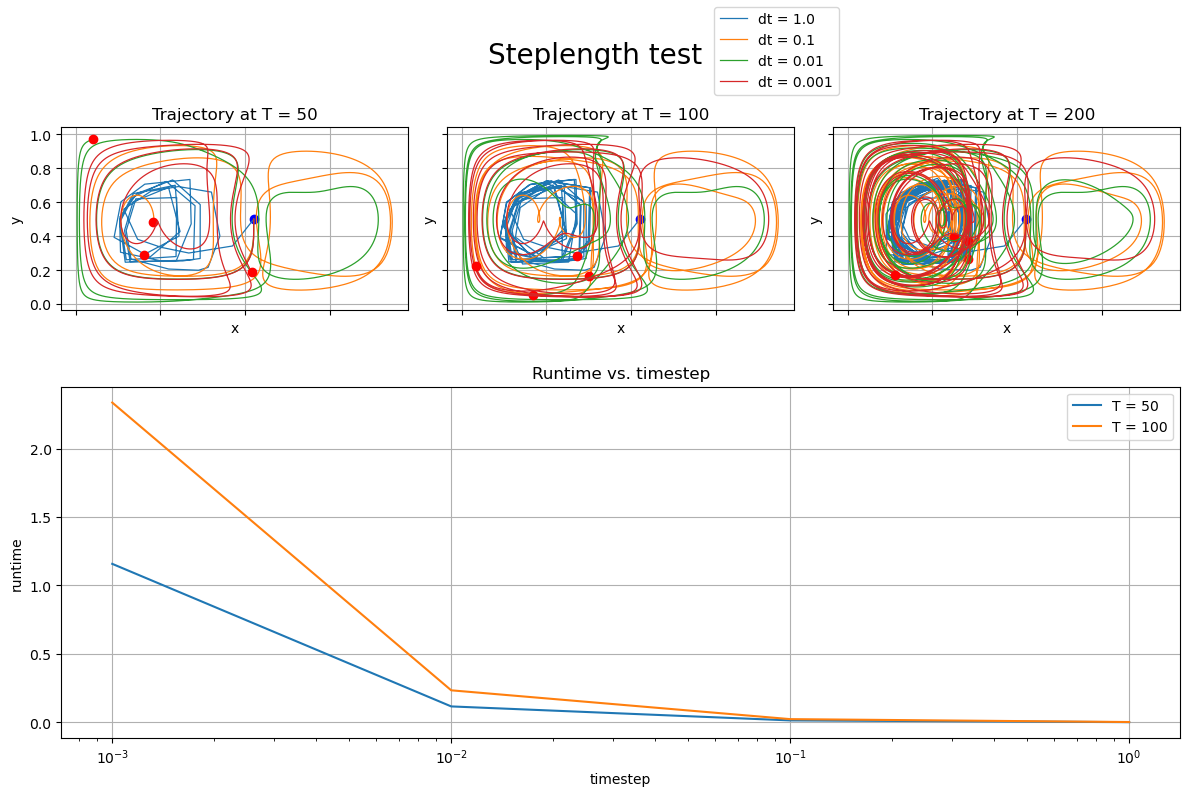

In [30]:
scatter_final_parameters = {"s": 5}
plot_parameters = {"alpha":1, "linewidth":0.9}

X0 = np.array([[1.05], [0.50]])
time_testvalues = np.array([50, 100, 200])
dt_testvalues = np.array([1, 0.1, 0.01, 0.001])

fig, ax = plt.subplots(2, len(time_testvalues), figsize=(12, 8), sharex=True, sharey=True)
ax[1, 0].remove()
ax[1, 1].remove()
ax[1, 2].remove()

ax[0, :], time_array = run_steplength_test(ax[0, :], velocity, X0, time_testvalues=time_testvalues, stepsize_testvalues=dt_testvalues, **plot_parameters)
bottom_ax = fig.add_subplot(212)
bottom_ax.plot(dt_testvalues, time_array[0, :], label="T = 50")
bottom_ax.plot(dt_testvalues, time_array[1, :], label="T = 100")
bottom_ax.set_xscale("log")
bottom_ax.set_title("Runtime vs. timestep")
bottom_ax.set_xlabel("timestep")
bottom_ax.set_ylabel("runtime")
bottom_ax.grid()
bottom_ax.legend()
fig.suptitle("Steplength test", fontsize=20, y = 0.95, x=0.5)
fig.legend(*ax[0, 0].get_legend_handles_labels(), loc=[0.6, 0.88])
plt.tight_layout(rect=[0, 0, 1, 1.02])
plt.show()


## Simulation of multiple particles in a $0.1 \times 0.1$ grid

For the first time interval $t \in [0, 50]$, the time-step $dt = 0.1$ seems to be suffiecient to represent the particle.
For the time interval $t \in [0, 100]$, $dt = 0.1$ deviates more from the shorter time steps, and is not short enough to represent the particle path correctly. With $dt = 0.01$ however, the approximation of the particle tracjectory is more accurate when comparing to the smaller timestep. 

Regarding the runtime, the biggest reduction happens when increasing $dt$ from 0.001 to 0.01. The graph shows a double in runtime when the time interval doubles, i.e. runtime is proportional to array length when using numpy arrays. For the time intervals tested here, the length of the arrays is not long enough for $dt$ to have a remarkable impact on runtime. For calculations going over several days, which will be the case later in the rapport, $dt$ will have to be considerably larger.

Due to the significant reduction in runtime, as well as the high accuracy of the trajectory, $dt = 0.01$ is the most economic timestep for these calculations.


In [31]:
from module.trajectory import Trajectory

trajectory_parameters = {
    "time_interval": [0, 10],
    "number_of_particles": 100,
    "stepsize": 0.01,
    "mode": "grid",
    "location": [-0.1, 0.1],
    "scale": 0.1,
}

traj = Trajectory(**trajectory_parameters)
traj(velocity)
traj.info()

Trajectory with:
Np: 100 particles
Time: [0, 10]
Time step: 0.01
Mode: grid
Check land: False
Velocity shape: (1000, 100)
X, Y shape: (100, 100)
U, V shape: (100, 100)
xmin: -1.3308532169979765, xmax: 1.119655549314349
ymin: -0.9981712094645157, ymax: 0.9981712094645157
Distance mean: 1.6726556791848577


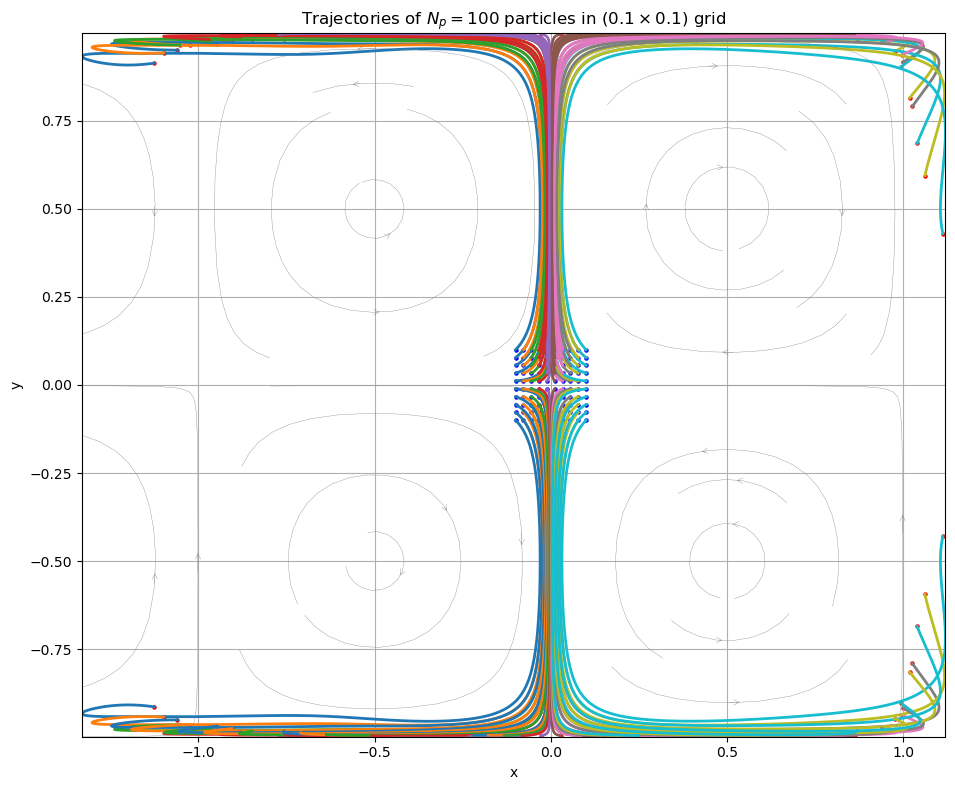

In [32]:
streamplot_parameters = {"color": "grey","density": 0.5,"linewidth": 0.25,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "c": "blue", "marker": "o", "label": "Initial position"}
scatter_final_parameters = {"s": 5, "c": "red", "marker": "o", "label": "Final position"}
plot_parameters = {"alpha":1, "linewidth":2}

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

traj.plot(ax, **plot_parameters)
traj.streamplot(ax, **streamplot_parameters)
traj.scatter(ax, t=0, **scatter_initial_parameters)
traj.scatter(ax, t=-1, **scatter_final_parameters)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Trajectories of $N_p = 100$ particles in $(0.1\\times 0.1)$ grid")
plt.grid()
plt.tight_layout()

plt.show()

Depending on the initial position of each particle, here only separated by a distance of 0.01 units, takes different paths. The time interval is here limited to $t \in [0, 10]$ The streamlines represent the velocity field at $t=0$ to give an idea of the impact of the current and wind. This will change with time, but keeps somewhat the same shape. The particles on the further right are caught by the streams to the right, and similarly on the left side. 

Trajectory with:
Np: 100 particles
Time: [0, 10]
Time step: 0.01
Mode: grid
Check land: False
Velocity shape: (1000, 100)
X, Y shape: (100, 100)
U, V shape: (100, 100)
xmin: -1.3308532169979765, xmax: 1.119655549314349
ymin: -0.9981712094645157, ymax: 0.9981712094645157
Distance mean: 1.6726556791848577


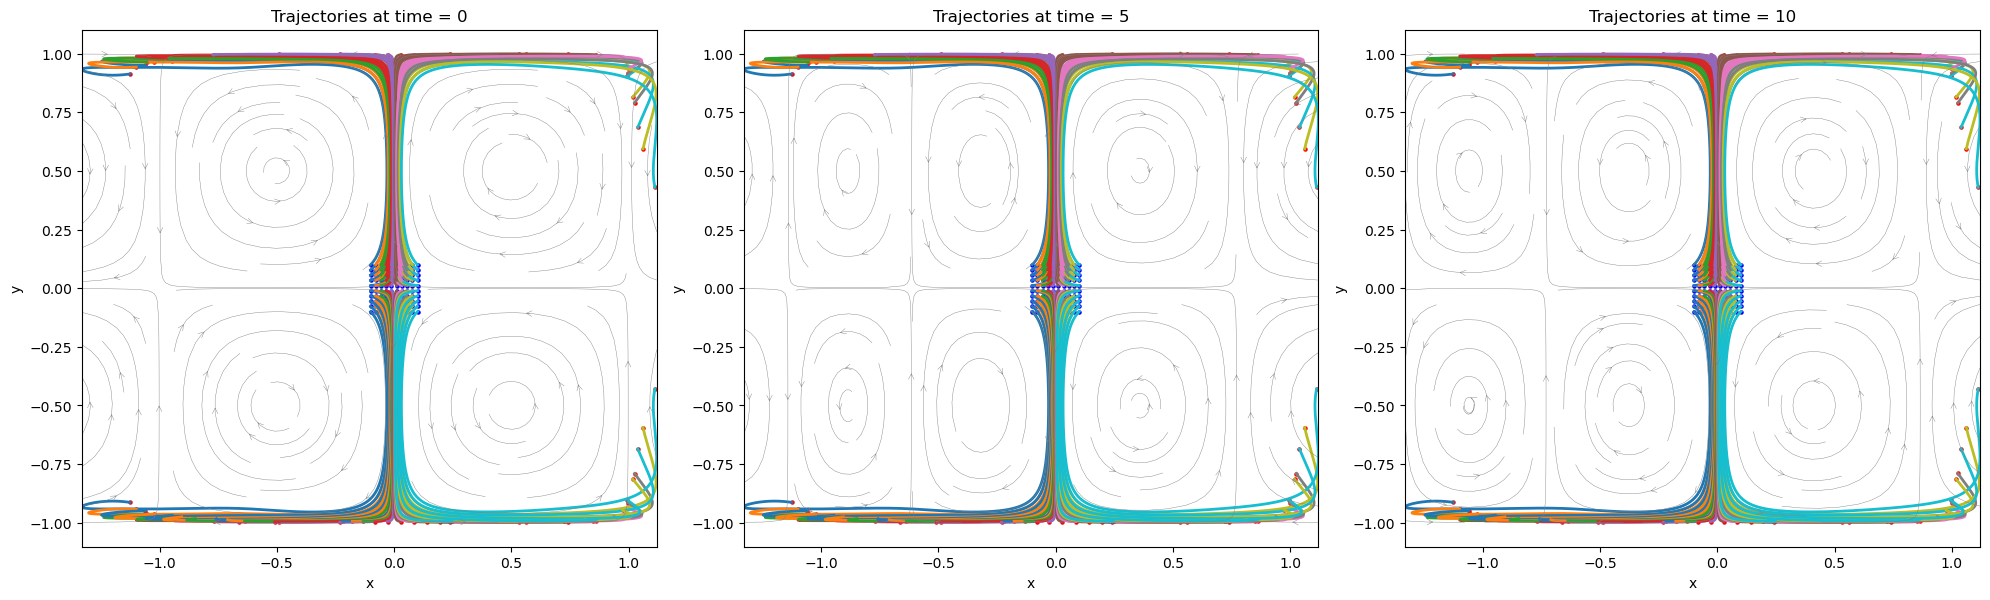

In [33]:
streamplot_parameters = {"color": "grey","density": 1,"linewidth": 0.3,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "c": "blue", "marker": "o", "label": "Initial position"}
scatter_final_parameters = {"s": 5, "c": "red", "marker": "o", "label": "Final position"}
plot_parameters = {"alpha":1, "linewidth":2}


traj = Trajectory(**trajectory_parameters)
traj(velocity)
traj.info()
time_velocity_field = [0, 5, 10]

fig, ax = plt.subplots(1, 3, figsize=(20, 12))

for i, time in enumerate(time_velocity_field):
    traj.plot(ax[i], **plot_parameters)
    traj.streamplot(ax[i],time_velocity_field = time, **streamplot_parameters)
    traj.scatter(ax[i], t=0, **scatter_initial_parameters)
    traj.scatter(ax[i], t=-1, **scatter_final_parameters)
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].set_title(f"Trajectories at time = {time}")

plt.tight_layout()
plt.show()

Depending on the time, here plotted at $t = 0$, $t=5$ and $t=10$, the velocity field changes some, but the overall shape remains quite similar.

## Correlation between number of particles and runtime


<Figure size 750x500 with 0 Axes>

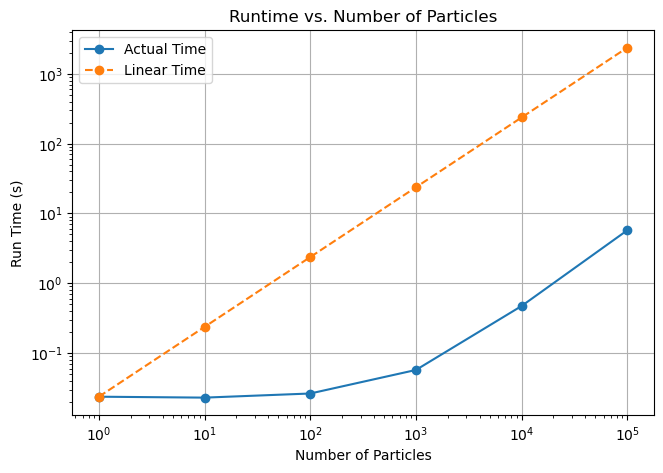

In [34]:
from module.utilities import run_timing_test
import numpy as np

dt = 0.01
time_interval = [0, 10]
Np_testvalues = [1, 10, 100, 1000, 10_000, 100_000]
times, linear_times = run_timing_test(interpolator=velocity, number_of_particles_testvalues = Np_testvalues, time_interval = time_interval, stepsize=0.01)

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(Np_testvalues, times, marker="o", label="Actual Time")
ax.plot(Np_testvalues, linear_times, marker="o", linestyle="--", label="Linear Time")

ax.set_title("Runtime vs. Number of Particles")
ax.set_xlabel("Number of Particles")
ax.set_ylabel("Run Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.grid(True)
plt.show()

The graph shows the curve is approximately constant for fewer particles, i.e. shorter arrays. When the number of particles reach approximately 1000, the run time takes on a linear increase.

For few particles, the linear increase may be too little to measure. The overhead time, in this case, is the time that python and jupyter cell/kernel uses as preparation for executing the task at hand. This overhead time can be few milliseconds, meaning if the running time of the numerical calculations are much smaller than the overhead time, there are no noticable variations between runtimes before it reaches a certain threshold. Here, this threshold seems to be reached when there are over 100 particles.

Another possible explanation for the constant runtime is how numpy allocates memory. For smaller array-sizes the compiler may overestimate how much memory needs to be allocated to avoid asking for new memory for every inceased index. Adding elements threrfore doesn't require additional runtime, resulting in constant time $\mathcal{O}(1)$. For bigger array-sizes, Python needs to allocate memory more frequently, resulting in a linear increase of runtime $\mathcal{O}(n)$.


---


# Simulation of plastic particles using wind and current data

## First simulation: Trondheimsfjorden


### Parameters

In [35]:
Np = 1000
days, dt = 5, 3600
T = [0, days * 24 * dt]
mode = "map"
loc, scale = [790_000, 490_000], 10_000
dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

streamplot_parameters = {"color": "grey","density": 1,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 2.5, "color": "darkblue"}
scatter_final_parameters = {"s": 2.5, "color": "green"}
plot_parameters = {"alpha": 0.3, "linewidth": 0.1,"color":"cornflowerblue"}

## Simulation projected on to the $xy$-plane

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 754777.7603019179, xmax: 954610.9777453167
ymin: 422006.63113246387, ymax: 521693.42873805185
Distance mean: 178809.49911334118
Windage factor: 0.03


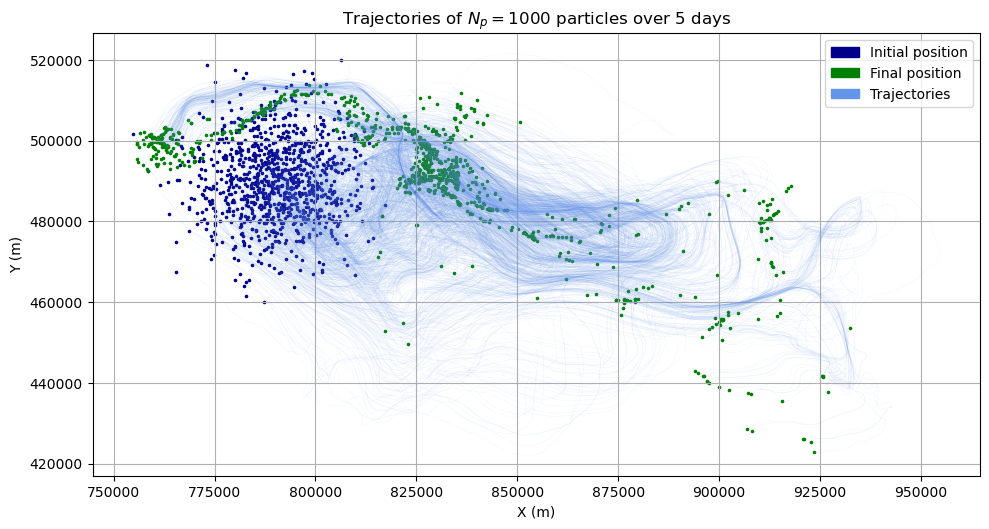

In [36]:
traj_grid = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode=mode, location=loc, scale=scale)
traj_grid(interpolator)
traj_grid.info()

fig, ax = plt.subplots(1, 1, figsize=(10,7))
traj_grid.plot(ax, **plot_parameters)
traj_grid.scatter(ax, t=0, label="Initial position", **scatter_initial_parameters)
traj_grid.scatter(ax, t=-1, label="Final position", **scatter_final_parameters)
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend(handles=[init_label, final_label, plot_label])
ax.grid()

plt.tight_layout()
plt.show()

Since the implementation of the numerical integrater *"Heun's method"* is quite fast, the number of particles can be in the range $N_p \in (0, 10000]$. For example, at $N_{(p, max)} = 10.000$, the run time is approximately one minute. 

Location and initial conditions are set at $t_0 = 0$ following a Gaussian distribution, within the $x$ and $y$ grid from the dataset. This grid represents the planar projection of Norway, including the shoreline.

In this example the location corresponds to the coast outside Trondheim.
$$(x_0, y_0) \backsim \mathcal{N}(\mu = (790000, 490000), \sigma = 10000)$$

In the five days showed in the plot, the trajectory lines show many of the particles taking a curved path as a result of the wind and current. For example at grid coordinate $(875000, 480000)$ the particles are most likely caught by a strong current, shifting their direction approximatly $180\degree $. 

## Simulation projected on world map

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 754222.6360834304, xmax: 968542.2766402247
ymin: 424314.17165296077, ymax: 526174.9838213351
Distance mean: 177478.38995932898
Windage factor: 0.03


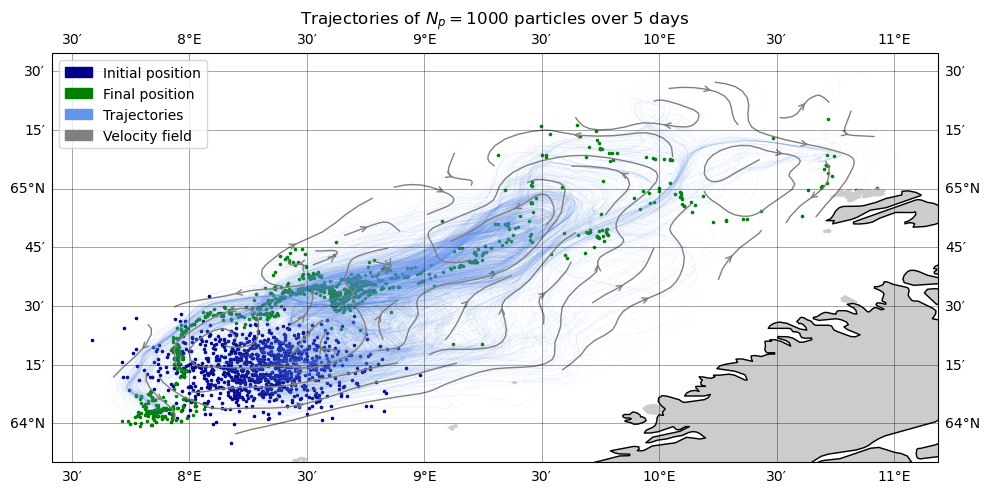

In [37]:
traj_map = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode="map", location=loc, scale=scale)
traj_map(interpolator)
traj_map.info()

fig, ax = plt.subplots(1,1, figsize=(10,7), subplot_kw={"projection": ccrs.PlateCarree()})

traj_map.init_map(ax, **plot_parameters)
traj_map.scatter(ax, t=0, label="initial position", **scatter_initial_parameters)
traj_map.scatter(ax, t=-1, label="final position", **scatter_final_parameters)
traj_map.streamplot(ax, **streamplot_parameters)
ax.legend(handles=[init_label, final_label, plot_label, stream_label])
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid()
plt.tight_layout()

plt.show()

The world map shows the same particle trajectory as the plot in the xy-plane above, where the turning point $(875000, 480000)$ here corresponds roughly to a latitude of $64.8 \degree N $ and a longitude of $9.4 \degree E$. This plot also illustrates the streamlines of the current and wind creating a vortex shape in this location, explaining the particles' sudden shift in direction.

## Comparing different initial conditions

In [71]:
streamplot_parameters = {"color": "gray","density": 1,"linewidth": 0.8,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}
plot_parameters = {"alpha": 0.4, "linewidth": 0.15,"color":"cornflowerblue"}

Trajectory with:
Np: 500 particles
Time: [0, 432000]
Time step: 3600
Mode: map
Check land: False
Velocity shape: (120, 500)
X, Y shape: (120, 500)
U, V shape: (120, 500)
xmin: 225935.5092546027, xmax: 424264.87033368676
ymin: 410279.52424420347, ymax: 528377.0757394636
Distance mean: 175397.119847562
Windage factor: 0.03


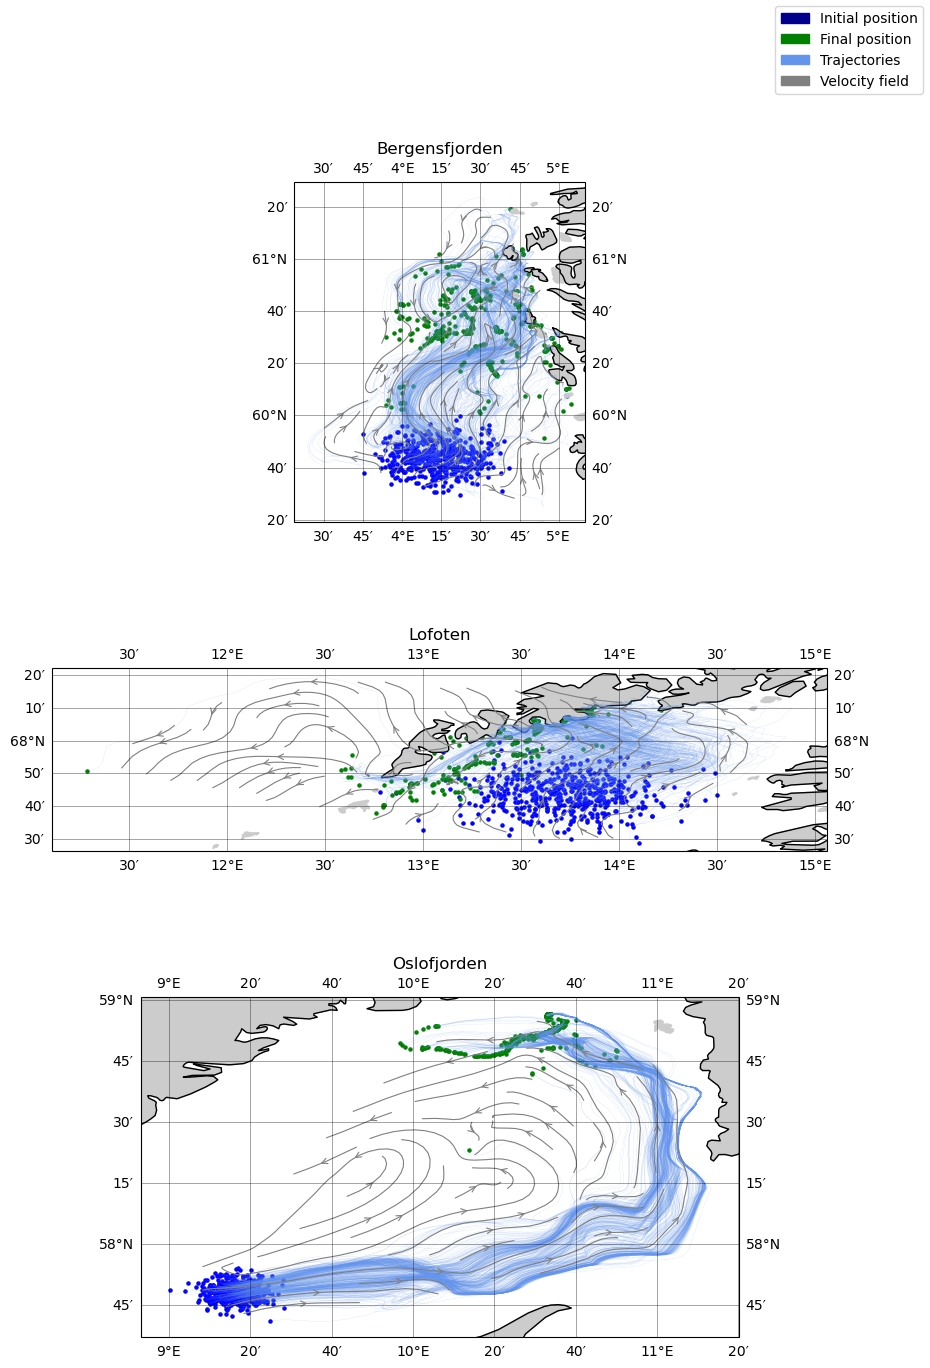

In [72]:
dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

Np=500
days = 5
time_interval = [0, days * 24 * 3600]
dt=3600
mode = "map"

fig, ax = plt.subplots(3,1,figsize=(10, 15), subplot_kw={"projection": ccrs.PlateCarree()})

ax[0].set_title("Bergensfjorden")
bergen, scale = [250000, 460000], 10000
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=bergen, scale=scale)
traj_bergen(interpolator)
traj_bergen.info()
traj_bergen.init_map(ax[0], **plot_parameters)
traj_bergen.streamplot(ax[0], **streamplot_parameters)
traj_bergen.scatter(ax[0], t=0, **scatter_initial_parameters)
traj_bergen.scatter(ax[0], t=-1, **scatter_final_parameters)


ax[1].set_title("Lofoten")
lofoten, scale = [1240000, 480000], 10000
traj_lofoten = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=lofoten, scale=scale)
traj_lofoten(interpolator)
traj_lofoten.init_map(ax[1], **plot_parameters)
traj_lofoten.streamplot(ax[1], **streamplot_parameters)
traj_lofoten.scatter(ax[1], t=0, **scatter_initial_parameters)
traj_lofoten.scatter(ax[1], t=-1, **scatter_final_parameters)

ax[2].set_title("Oslofjorden")
oslo, scale = [190_000, 100_000], 4000
traj_oslo = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=oslo, scale=scale)
traj_oslo(interpolator)
traj_oslo.init_map(ax[2], **plot_parameters)
traj_oslo.streamplot(ax[2], **streamplot_parameters)
traj_oslo.scatter(ax[2], t=0, **scatter_initial_parameters)
traj_oslo.scatter(ax[2], t=-1, **scatter_final_parameters)

fig.legend(handles=[init_label, final_label, plot_label, stream_label])
plt.show()

The plots show three simulations of $N_p = 500$ particle trajectories, in Bergensfjorden, outside Lofoten, and in Oslofjorden. The areas seem to have different path trends. Outside Bergensfjorden the wind and current is directed in various directions, resulting in a larger spread in the trajectories and final positions. The particles are first dragged in towards the shore, before being pulled out again.

The currents outside Lofoten seems to pull the particles out from the shore, resulting in a accumulation by the shoreline. The silulation does not take into account 

The particles in Oslofjorden follow a very homogenous curved path, where they end up along a continuous line.


# Simulation of particles reaching land



In [73]:
streamplot_parameters = {"color": "grey","density": 0.5,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
plot_parameters = {"color": "cornflowerblue", "alpha": 0.4, "linewidth": 0.1}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}

In [78]:
Np=500
days = 3
time_interval = [0, days * 24 * 3600]
dt=3600
mode = "map"
loc, scale = [250_000, 460_000], 10000
time_array = np.arange(0, time_interval[1]-dt, dt)

interpolator = Interpolator(dataset=dataset)
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
traj_bergen(interpolator)
traj_bergen.info()

Trajectory with:
Np: 500 particles
Time: [0, 259200]
Time step: 3600
Mode: map
Check land: True
Velocity shape: (72, 500)
X, Y shape: (72, 500)
U, V shape: (72, 500)
xmin: 200493.56264003058, xmax: 409927.42396380653
ymin: 416874.24304679764, ymax: 514493.70984709525
Distance mean: 125897.18339528929
Land percent: 14.6%
Land particles: 72
Windage factor: 0.03


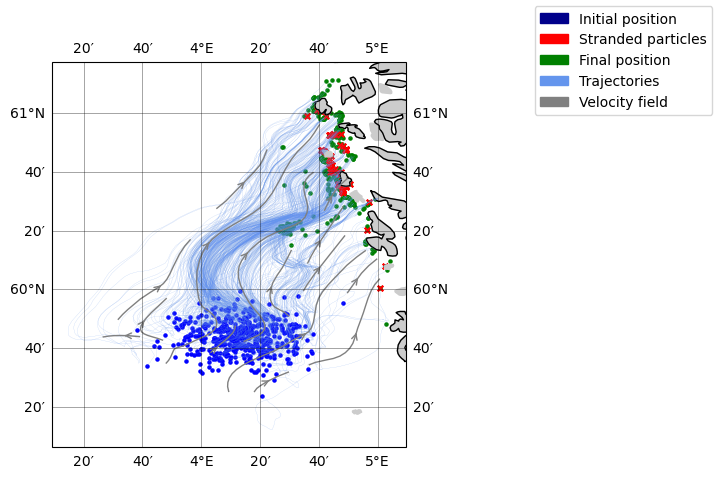

In [79]:
fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
traj_bergen.init_map(ax, **plot_parameters)
traj_bergen.plot(ax, **plot_parameters)
traj_bergen.scatter(ax, t=0, **scatter_initial_parameters)
traj_bergen.scatter(ax, t=-1, **scatter_final_parameters)
traj_bergen.streamplot(ax, **streamplot_parameters)
landed_percent = traj_bergen.get_land_percent()
fig.legend(handles=[init_label, stranded_label, final_label, plot_label, stream_label])

The red points indicate where particles have reached land. Without this feature, as shown earlier of Bergensfjorden, the particles seem to move out from land. This plot shows they stop at shore, instead of being caught by the outward stream.

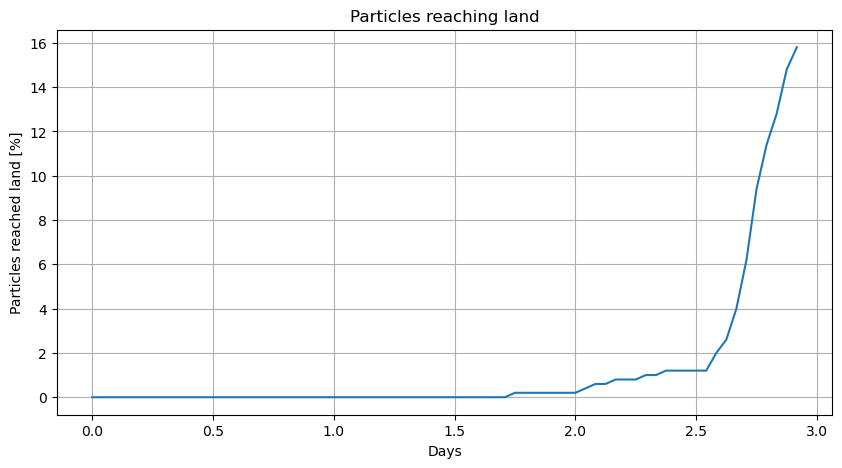

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_array/(3600*24), landed_percent)
ax.set_title('Particles reaching land')
ax.set_xlabel('Days')
ax.set_ylabel('Particles reached land [%]')
ax.grid()
plt.show()

In this example the initial conditions were placed on the west coast, where the wind and ocean current-vectors are pointing towards the shore. As expected the amount of particles reaching land therefore increases with time. After three days, about 40% of the particles have reached shore.

## ( 3-b ) 

With the same initial conditions as above, try a few different windage factors, in
the range from 0 to 0.15, and show how this affects the results. You can for example
look into the percentage of particles that become stranded after three days as a
function of fw. Note that the results may of course depend on where (and when)
you start the particle trajectories, and for some initial conditions no particles will
reach land at all


In [43]:
streamplot_parameters = {"color": "seagreen","density": 0.5,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
plot_parameters = {"color": "cornflowerblue", "alpha": 0.5, "linewidth": 0.1}
scatter_initial_parameters = {"s": 5, "color": "blue"}
scatter_final_parameters = {"s": 5, "color": "green"}

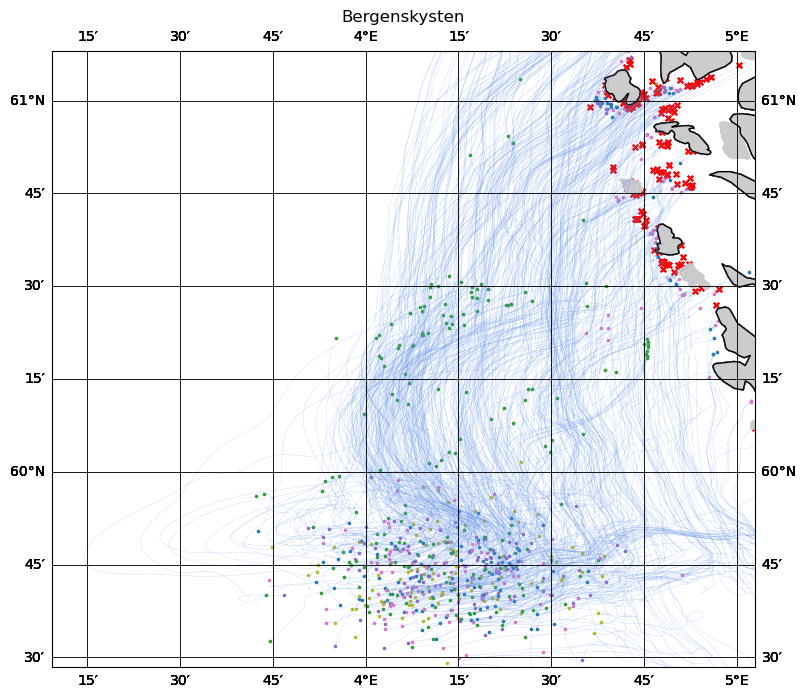

In [44]:
fw = np.linspace(0, 0.15, 5)

fig, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection": ccrs.PlateCarree()})

landed_percent = []
for w in fw:
    dataset = xr.open_dataset("data/NorKyst-800m.nc")
    interpolator = Interpolator(dataset=dataset, fw=w)
    traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
    traj_bergen(interpolator)
    traj_bergen.init_map(ax, **plot_parameters)
    traj_bergen.plot(ax, **plot_parameters)
    traj_bergen.scatter(ax, t=0, **{"label": "Initial Position","s":2.5})
    traj_bergen.scatter(ax, t=-1, **{"label": "Final Position", "s":2.5})

    percent = traj_bergen.get_land_percent()
    landed_percent.append(percent)


ax.set_title("Bergenskysten")
plt.show()

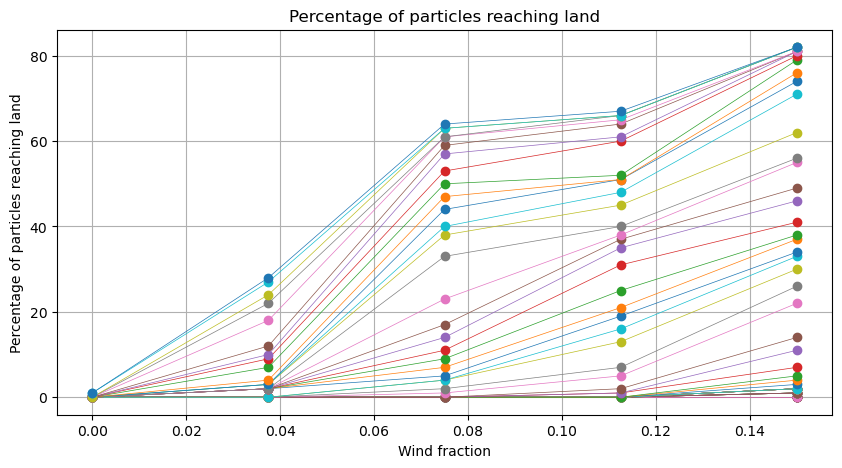

In [45]:
x = np.array(fw)
y = np.array(landed_percent)


fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(x, y, marker="o", linewidth=0.5)
ax.set_title("Percentage of particles reaching land")
ax.set_xlabel("Wind fraction")
ax.set_ylabel("Percentage of particles reaching land")
ax.grid()
plt.show()

---

## References

[1]: Meteorologisk Institutt. Retrieved 3. April 2024. NorKyst Data. https://thredds.met.no/thredds/catalog/fou-hi/norkyst800m-1h/catalog.html